# Data Visualization

### Import packages

In [1]:
%matplotlib inline
import pandas as pd
import requests
import geopandas as gpd
from tqdm import tqdm
from collections import OrderedDict
import shapely
from shapely.geometry import shape
import numpy as np
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')

### Analysis 1
#### Daily mentions of Xi Jinping

In [2]:
# Read data
content_df = pd.read_csv("../data/1_xwlb_content_title_daily.csv", encoding='gb18030')

# Set the date column of content_df to be a column of type datetime 
# This enables us to get easy access to datetime functions
content_df['date'] = pd.to_datetime(content_df['date'], format='%Y-%m-%d')

# Get weekday from date column, create a column to signify if that date is a weekend
content_df['day_of_week'] = content_df['date'].dt.weekday
content_df['is_weekend'] = content_df.day_of_week.map(lambda x: x > 4)

def compute_cond(df, in_col, texts):
    '''
    compute whether a column contains certain texts
    input: df: dataframe of interest
           in_col: the column of interest, ultimately we want to know if this column contains one of the texts
           texts: the strings that we want to know if in_col column contains any one of them
    '''
    # Initialize a series of False that is later used to "or" against column evaluation results on texts
    result_series = pd.Series(data=[False]*df.shape[0], index=range(df.shape[0]))
    
    # For each text in texts, create a boolean series that tells us whether each row contains the text
    # Then take the truth value of the "or" operation on the new boolean column against previous columns
    for text in texts:
        result_series |= content_df[in_col].str.contains(text)
    return result_series

content_df['content_contains_xjp'] = compute_cond(content_df, 'content', [u'习近平', u'总书记', u'习主席'])
content_df['content_contains_lkq'] = compute_cond(content_df, 'content', [u'李克强'])

#### Turn each daily transcript into a dictionary

In [3]:
# content_dict: { date : concatenate all content of the day, regardless of sections / titles }
content_dict = content_df.fillna('').groupby('date').agg({
    'content': lambda x: ''.join(x)
}).to_dict()

#### Plot the daily mention of Xi Jinping 

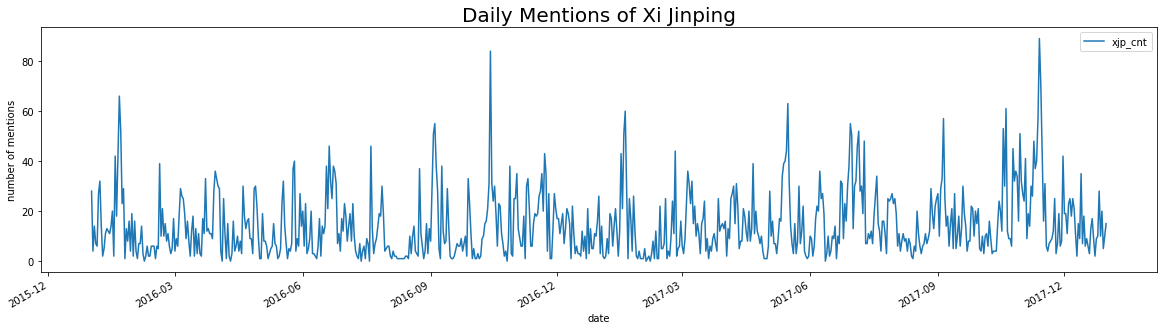

In [4]:
# xjp_daily_cnt: { 'xjp_cnt' : { date : appearences of 'Xi Jinping' } }
xjp_daily_cnt = {
    'xjp_cnt': {
        k: v.count(u'习近平') + v.count(u'习主席') + v.count(u'习总书记') 
        for k, v in content_dict['content'].items()
    }
}

# Set plotting parameters (figure size)
plt.rcParams['figure.figsize'] = (20, 5)

# create a dataframe based on xjp_daily_cnt dictionary, and plot daily mentions
xjp_ax = pd.DataFrame(xjp_daily_cnt).plot()
xjp_ax.set_title('Daily Mentions of Xi Jinping', fontdict={'size': 20})
xjp_ax.set_xlabel('date')
xjp_ax.set_ylabel('number of mentions');

#### Export the plot

In [5]:
f = xjp_ax.get_figure()
f.savefig('../results/result1_xwlb_daily_XJP_mentions.png')

### Analysis 2 (No plot)
#### Number of Sections with Xi Jinping and Li Keqiang (PM)

In [6]:
# Create a dictionary of column name to texts mapping
# The purpose is to be able to create pandas columns easily using the previuosly defined function
dict_of_texts = {
    'xjp': [u'习近平', u'总书记', u'习主席'], 
    'lkq': [u'李克强']
}

def compute_freq(df, along, in_col, dict_of_texts):
    '''
    inputs: df: dataframe of interest
            along: a column to group along, also serves as the denominator when we compute frequencies
            in_col: which column to see if it contains the required text
            dict_of_texts: { column name : list of texts }
    outputs: { column name: (number of rows containing texts, frequency) }, an integer denominator
    '''
    
    # Remove NaNs in columns
    df = df.dropna()
    
    # Denominator defined as unique elements in the along column
    denom = df[along].nunique()
    results = {}
    for key, texts in dict_of_texts.items():
        
        # format column name
        col_name = '{}_contains_{}'.format(in_col, key)
        
        # set column to be the truth value of whether it contains the text
        df[col_name] = compute_cond(df, in_col, texts)
        
        # numerator is the grouped result. 
        # For example, we can group all contents in a title together 
        # and judge whether the title contains the text
        numerator = df.groupby(along).agg({col_name: any}).sum()
        numerator = numerator.values[0]
        results[col_name] = numerator, numerator / denom
    return results, denom

compute_freq(content_df, 'title', 'content', dict_of_texts)

({'content_contains_lkq': (1408, 0.09745968021042431),
  'content_contains_xjp': (3248, 0.22482176230359244)},
 14447)

There are 14,447 sections across the 2-year span, within which 2809 mentioned Xi Jinping, and 882 mentioned Li Keqiang.

### Analysis 3: Frequency of Mentions across Provinces
#### Match the Pinyin and Chinese character names of provinces, autonomous regions, and directly-controlled municipalities

In [7]:
provinces = {
    'Beijing': [u'北京'], 
    'Tianjin': [u'天津'], 
    'Shanghai': [u'上海'],
    'Chongqing': [u'重庆'],
    'Hebei': [u'河北'],
    'Shanxi': [u'山西'],
    'Liaoning': [u'辽宁'],
    'Jilin': [u'吉林'], 
    'Heilongjiang': [u'黑龙江'], 
    'Jiangsu': [u'江苏'],
    'Zhejiang': [u'浙江'],
    'Anhui': [u'安徽'],
    'Fujian': [u'福建'],
    'Jiangxi': [u'江西'],
    'Shandong': [u'山东'], 
    'Henan': [u'河南'], 
    'Hubei': [u'湖北'],
    'Hunan': [u'湖南'],
    'Guangdong': [u'广东'],
    'Hainan': [u'海南'],
    'Sichuan': [u'四川'],
    'Guizhou': [u'贵州'], 
    'Yunnan': [u'云南'],
    'Shaanxi': [u'陕西'],
    'Gansu': [u'甘肃'],
    'Qinghai': [u'青海'],
    'Taiwan': [u'台湾'],
    'Inner_Mongolia': [u'内蒙古'], 
    'Guangxi': [u'广西'], 
    'Tibet': [u'西藏'],
    'Ningxia': [u'宁夏'],
    'Xinjiang': [u'新疆'],
    'Hongkong': [u'香港'],
    'Macau': [u'澳门']
}

#### Compute the mentions of each provinces

In [8]:
compute_freq(content_df, 'title', 'content', provinces)

({'content_contains_Anhui': (790, 0.05468263307261023),
  'content_contains_Beijing': (1974, 0.13663736415864886),
  'content_contains_Chongqing': (740, 0.05122170692877414),
  'content_contains_Fujian': (788, 0.054544196026856784),
  'content_contains_Gansu': (761, 0.0526752959091853),
  'content_contains_Guangdong': (798, 0.055236381255624),
  'content_contains_Guangxi': (743, 0.051429362497404305),
  'content_contains_Guizhou': (785, 0.05433654045822662),
  'content_contains_Hainan': (724, 0.05011421056274659),
  'content_contains_Hebei': (851, 0.05890496296809026),
  'content_contains_Heilongjiang': (724, 0.05011421056274659),
  'content_contains_Henan': (788, 0.054544196026856784),
  'content_contains_Hongkong': (779, 0.05392122932096629),
  'content_contains_Hubei': (779, 0.05392122932096629),
  'content_contains_Hunan': (772, 0.053436699660829236),
  'content_contains_Inner_Mongolia': (795, 0.05502872568699384),
  'content_contains_Jiangsu': (901, 0.06236588911192635),
  'conten

#### Create a label for whether the segment is about weather
I noticed that weather reports and natural disaterare sometimes included. That means that certain provinces are more likely to be mentioned given that some are more likely to experience extreme weathers or natural disasters. Therefore, I removed all the paragraphs that mentioned "weather" or "earthquake."

In [9]:
content_df['content_contains_nature'] = compute_cond(content_df, 'content', [u'气象', u'地震'] )
content_wo_nature = content_df[~content_df.content_contains_nature]
content_df.to_csv("../data/2_xwlb_content_title_daily_labeled.csv", index=False, encoding='gb18030')

#### Compute the mentions of each provinces again

In [10]:
compute_freq(content_wo_nature, 'title', 'content', provinces)

({'content_contains_Anhui': (965, 0.06703716568252865),
  'content_contains_Beijing': (2140, 0.14866273011462314),
  'content_contains_Chongqing': (928, 0.0644668287599861),
  'content_contains_Fujian': (978, 0.06794025703369225),
  'content_contains_Gansu': (948, 0.06585620006946856),
  'content_contains_Guangdong': (974, 0.06766238277179576),
  'content_contains_Guangxi': (925, 0.06425842306356373),
  'content_contains_Guizhou': (973, 0.06759291420632164),
  'content_contains_Hainan': (912, 0.06335533171240014),
  'content_contains_Hebei': (1041, 0.072316776658562),
  'content_contains_Heilongjiang': (915, 0.06356373740882251),
  'content_contains_Henan': (977, 0.06787078846821813),
  'content_contains_Hongkong': (977, 0.06787078846821813),
  'content_contains_Hubei': (963, 0.06689822855158041),
  'content_contains_Hunan': (959, 0.06662035428968392),
  'content_contains_Inner_Mongolia': (974, 0.06766238277179576),
  'content_contains_Jiangsu': (1082, 0.07516498784300105),
  'content_

#### Output Province Mentions Data

In [11]:
province_dict = compute_freq(content_wo_nature, 'title', 'content', provinces)[0]
province_df = pd.DataFrame({'mentions': {k: v[0] for k, v in province_dict.items()}})
province_df.to_csv('../data/3_xwlb_daily_province_mentions.csv')

#### Transform the province column

In [12]:
province_df = pd.read_csv('../data/3_xwlb_daily_province_mentions.csv')
province_df.columns = ['province', 'mentions']

# Previuosly the province column is of form 'content_contains_Anhui'
# We want to extract 'Anhui' from that string for the geolocation mapping purpose
province_df.province = province_df.province.map(lambda x: " ".join(x.split('_')[2:]))
province_df.head()

,province,mentions
0,Anhui,965
1,Beijing,2140
2,Chongqing,928
3,Fujian,978
4,Gansu,948


#### Query for province coordinates

In [13]:
# Define a function to, given the province, return the polygon shape of the province
def nominatim_query(state):
    # Parameters used in the http request
    params = OrderedDict()
    params['format'] = 'json'
    params['limit'] = 1
    params['dedupe'] = 1
    params['polygon_geojson'] = 1
    params['country'] = 'PRC'
    params['state'] = state
    
    # Use the nominatim search request
    url = 'https://nominatim.openstreetmap.org/search'
    prepared_url = requests.Request('GET', url, params=params).prepare().url
    
    # get the respons and put it into a json format
    response = requests.get(url, params=params)  
    response_json = response.json()
    
    # Else statement needed to deal with the case of Hong Kong, which is not treated as a state.
    if len(response_json) > 0:
        return shape(response_json[0]['geojson'])
    else:
        params['q'] = state
        del params['state']
        response = requests.get(url, params=params)
        response_json = response.json()
        return shape(response_json[0]['geojson'])

#### Prepare the base plot of the Chinese map

In [14]:
# Get the shape for each province, and put the geometry info in a GeoDataFrame
province_polygon = [nominatim_query(k) for k in tqdm(province_df.province.values)]
geo_df = gpd.GeoDataFrame(geometry=province_polygon)
geo_df['province_name'] = province_df.province
geo_df.head()

100%|██████████| 34/34 [00:42<00:00,  1.25s/it]


,geometry,province_name
0,"POLYGON ((114.8766517 32.9918914, 114.8775958 ...",Anhui
1,"POLYGON ((115.4172086 39.9684207, 115.4205984 ...",Beijing
2,"(POLYGON ((105.2868306 29.5555517, 105.2878484...",Chongqing
3,"POLYGON ((115.8467567 25.1677106, 115.849899 2...",Fujian
4,"POLYGON ((92.3386502 39.2373639, 92.3414826000...",Gansu


#### Remove Macau due to data irregularity

In [15]:
geo_df = geo_df[geo_df.province_name != 'Macau']

#### Plot the frequencies of mentions

Text(528.174,0.5,'latitude')

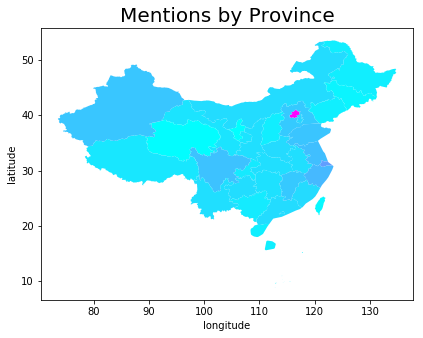

In [16]:
# Use the log of mentions to mitigate the "capital effect"
# i.e. Beijing being excessively mentioned in CCTV's Nightly News 

geo_df['mentions_log'] = province_df.mentions.map(np.log)
vmin = geo_df.mentions_log.min()
vmax = geo_df.mentions_log.max()

# Plot the graph
ax = geo_df.plot(column='mentions_log', cmap='cool', vmin=vmin, vmax=vmax)
ax.set_title('Mentions by Province', fontdict={'size': 20})
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

#### Export the plot

In [17]:
f = ax.get_figure()
f.savefig('../results/result2_xwlb_daily_province_mentions.png')